In [1]:
import utils
from utils.audio_utils import *
from utils.audio_models import *
import os
import librosa
import soundfile as sf
from IPython.display import display, Audio
import joblib

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


# Take a look at the model

In [3]:
# Load the saved model

# CNN
loaded_model_cnn = load_model('models/cnn/CNN_drop_l2.keras')

# Autoencoder SVM
loaded_model_svm = joblib.load('models/autoencoder/autoencoder_svm_model.pkl')

# Inception
loaded_model_inc = load_model('models/Inception/Inception_model.keras')

# Display the model summary
loaded_model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 97, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 5, 32)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 5, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 3, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 1, 64)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 1, 64)         0

# Take a look at the labels

In [4]:
# Load the saved label encoder
# CNN
loaded_label_encoder_cnn = joblib.load('models/cnn/label_encoder_cnn.pkl')

# SVM
loaded_label_encoder_svm = joblib.load('models/autoencoder/label_encoder_autoencoder_svm.pkl')

# Inception
loaded_label_encoder_inc = joblib.load('models/Inception/label_encoder_Inception.pkl')


# Display the unique classes in the label encoder
# CNN
unique_classes_cnn = loaded_label_encoder_cnn.categories_

#SVM
unique_classes_svm = loaded_label_encoder_svm.categories_

# Inception
unique_classes_inc = loaded_label_encoder_inc.categories_

print("Unique classes in the label encoder:", unique_classes_cnn)

Unique classes in the label encoder: [array(['backward', 'bed', 'cat', 'eight', 'go', 'happy', 'learn', 'right',
       'tree'], dtype='<U8')]


# Convert data

### Listen to the recorded file of the word

In [5]:
output_file = 'Inference/inference_data/happy_right.wav'

# Load and display the audio file
audio_data, rate = librosa.load(output_file, sr=None)
Audio(audio_data, rate=rate)

In [6]:
# Load the audio file
output_file = 'Inference/inference_data/happy_right.wav'
audio_data, rate = librosa.load(output_file, sr=None)

# Find the non-silent intervals
intervals = librosa.effects.split(audio_data, top_db=20)

# Specify the output folder
output_folder = 'Inference/output_folder'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Save each interval as a separate subfile in the output folder
for i, (start, end) in enumerate(intervals):
    subfile = audio_data[start:end]
    subfile_path = os.path.join(output_folder, f'subfile_{i + 1}.wav')
    sf.write(subfile_path, subfile, rate)
    print(f'Saved subfile {i + 1} to {subfile_path}')
    
    # Play the subfile
    display(Audio(subfile, rate=rate))


Saved subfile 1 to Inference/output_folder/subfile_1.wav


Saved subfile 2 to Inference/output_folder/subfile_2.wav


Saved subfile 3 to Inference/output_folder/subfile_3.wav


Saved subfile 4 to Inference/output_folder/subfile_4.wav


In [7]:
sig_array, mfcc_array, files = inference_sig_to_mfcc(output_folder, intervals)

# CNN

In [8]:
mfcc_array_cnn = np.array(mfcc_array)

mfcc_array_reshaped_cnn = mfcc_array_cnn[..., np.newaxis]

# Make predictions on the test set
Y_pred_cnn = loaded_model_cnn.predict(mfcc_array_reshaped_cnn)

# Decode one-hot encoded labels
Y_pred_decoded_labels_cnn = loaded_label_encoder_cnn.inverse_transform(Y_pred_cnn)

1/1 [==============================] - 0s 144ms/step


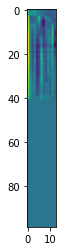

In [9]:
image = mfcc_array_reshaped_cnn[0]

# Plotting the array as an image
plt.imshow(image)

In [10]:
Y_pred_decoded_labels_cnn

array([['go'],
       ['bed'],
       ['eight'],
       ['happy']], dtype='<U8')

In [11]:
folder_path = 'Inference/output_folder'

# Get a list of all .wav files in the folder
wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

# Iterate over each .wav file
for wav_file in wav_files:
    # Construct the full path to the .wav file
    full_path = os.path.join(folder_path, wav_file)
    
    # Load the audio data
    audio_data, rate = librosa.load(full_path, sr=None)
    
    # Display the filename
    print(f'Playing: {wav_file}')
    
    # Play the audio
    display(Audio(audio_data, rate=rate))

Playing: subfile_3.wav


Playing: subfile_2.wav


Playing: subfile_1.wav


Playing: subfile_4.wav


# SVM

In [23]:
mfcc_array_svm = np.array(mfcc_array)

mfcc_array_reshaped_svm = mfcc_array_inc[..., np.newaxis]

# Specify the amount of padding for each dimension
pad_width = ((0, 0), (0, 1), (3, 4), (0, 0))

# Pad the array to the desired shape
mfcc_array_padded_svm = np.pad(mfcc_array_reshaped_svm, pad_width, mode='constant')

# Make predictions on the test set
Y_pred_svm = loaded_model_inc.predict(mfcc_array_padded_svm)

# Decode one-hot encoded labels
Y_pred_decoded_labels_svm = loaded_label_encoder_svm.inverse_transform(Y_pred_svm)

1/1 [==============================] - 0s 27ms/step


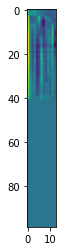

In [24]:
image = mfcc_array_reshaped_svm[0]

# Plotting the array as an image
plt.imshow(image)

In [25]:
Y_pred_decoded_labels_svm

array([['go'],
       ['bed'],
       ['eight'],
       ['happy']], dtype='<U8')

In [26]:
folder_path = 'Inference/output_folder'

# Get a list of all .wav files in the folder
wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

# Iterate over each .wav file
for wav_file in wav_files:
    # Construct the full path to the .wav file
    full_path = os.path.join(folder_path, wav_file)
    
    # Load the audio data
    audio_data, rate = librosa.load(full_path, sr=None)
    
    # Display the filename
    print(f'Playing: {wav_file}')
    
    # Play the audio
    display(Audio(audio_data, rate=rate))

Playing: subfile_3.wav


Playing: subfile_2.wav


Playing: subfile_1.wav


Playing: subfile_4.wav


# Inception

In [19]:
mfcc_array_inc = np.array(mfcc_array)

mfcc_array_reshaped_inc = mfcc_array_inc[..., np.newaxis]

# Specify the amount of padding for each dimension
pad_width = ((0, 0), (0, 1), (3, 4), (0, 0))

# Pad the array to the desired shape
mfcc_array_padded_inc = np.pad(mfcc_array_reshaped_inc, pad_width, mode='constant')

# Make predictions on the test set
Y_pred_inc = loaded_model_inc.predict(mfcc_array_padded_inc)

# Decode one-hot encoded labels
Y_pred_decoded_labels_inc = loaded_label_encoder_inc.inverse_transform(Y_pred_inc)

1/1 [==============================] - 0s 333ms/step


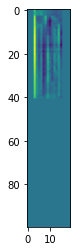

In [20]:
image = mfcc_array_padded_inc[0]

# Plotting the array as an image
plt.imshow(image)

In [21]:
Y_pred_decoded_labels_inc

array([['go'],
       ['bed'],
       ['eight'],
       ['happy']], dtype='<U8')

In [22]:
folder_path = 'Inference/output_folder'

# Get a list of all .wav files in the folder
wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

# Iterate over each .wav file
for wav_file in wav_files:
    # Construct the full path to the .wav file
    full_path = os.path.join(folder_path, wav_file)
    
    # Load the audio data
    audio_data, rate = librosa.load(full_path, sr=None)
    
    # Display the filename
    print(f'Playing: {wav_file}')
    
    # Play the audio
    display(Audio(audio_data, rate=rate))

Playing: subfile_3.wav


Playing: subfile_2.wav


Playing: subfile_1.wav


Playing: subfile_4.wav


# Record a New word to test

In [ ]:
import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write

# Set the file name for recording
output_file = 'Inference/inference_data/happy_right.wav'
duration = 5  # 1 second

# Record the audio
print(f"Recording {duration} seconds. Speak the word.")
audio_data = sd.rec(int(rate * duration), samplerate=rate, channels=1, dtype=np.int16)
sd.wait()

# Save the recorded audio
write(output_file, rate, audio_data)

print(f"Audio recorded and saved as {output_file}")


backward' 'bed' 'cat' 'eight' 'go' 'happy' 'learn' 'right' 'tree'